# Проект 4. "Банковский скоринг"
# Выполнен Шашановым М. (SF-DST-12)
## Задача проекта: прогнозирование вероятности дефолта заемщика

### Импортируем необходимые библиотеки

In [178]:
import pandas as pd
from pandas import Series
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, plot_confusion_matrix

from datetime import date
import credit_scoring_kernel_module as my

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/sample_submission.csv


In [179]:
pd.set_option('display.max_columns', 250) # показывать больше колонок
pd.set_option('display.max_rows', 250) # показывать больше строк

In [180]:
train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
test = pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')

In [181]:
train.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


Получим информацию о датасетах

In [182]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

(None, None)

In [183]:
train.columns, test.columns

(Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
        'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
        'region_rating', 'home_address', 'work_address', 'income', 'sna',
        'first_time', 'foreign_passport', 'default'],
       dtype='object'),
 Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
        'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
        'region_rating', 'home_address', 'work_address', 'income', 'sna',
        'first_time', 'foreign_passport'],
       dtype='object'))

Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

Проверим наличие пропусков в датасете

In [184]:
train.isnull().sum(), test.isnull().sum()

(client_id             0
 app_date              0
 education           307
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 default               0
 dtype: int64,
 client_id             0
 app_date              0
 education           171
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 dtype: int64)

Для наглядности посмотрим на данный признак на графике

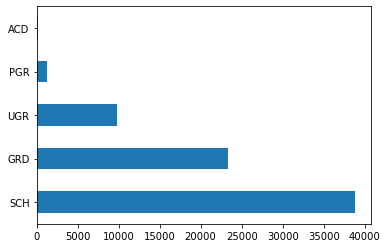

In [185]:
train['education'].value_counts().plot.barh()

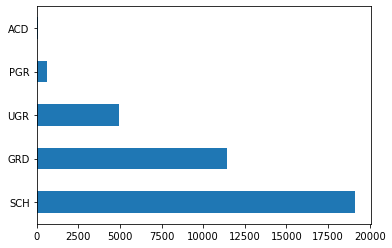

In [186]:
test['education'].value_counts().plot.barh()

Заполним пропуски значением, которое встречается чаще всего

In [187]:
# fill NaN with the most frequent value

import collections

c_1 = collections.Counter(train['education'])
c_2 = collections.Counter(test['education'])

train['education'].fillna(c_1.most_common()[0][0], inplace=True)
test['education'].fillna(c_2.most_common()[0][0], inplace=True)

Проверим успешность заполнения

In [188]:
train.isnull().sum(), test.isnull().sum()

(client_id           0
 app_date            0
 education           0
 sex                 0
 age                 0
 car                 0
 car_type            0
 decline_app_cnt     0
 good_work           0
 score_bki           0
 bki_request_cnt     0
 region_rating       0
 home_address        0
 work_address        0
 income              0
 sna                 0
 first_time          0
 foreign_passport    0
 default             0
 dtype: int64,
 client_id           0
 app_date            0
 education           0
 sex                 0
 age                 0
 car                 0
 car_type            0
 decline_app_cnt     0
 good_work           0
 score_bki           0
 bki_request_cnt     0
 region_rating       0
 home_address        0
 work_address        0
 income              0
 sna                 0
 first_time          0
 foreign_passport    0
 dtype: int64)

Проверим возможное присутствие дубликатов по признаку client_id, который должен быть уникальным в каждой строке

In [189]:
duplicates_check = []
duplicates_check.append(train['client_id'].nunique() == train.shape[0])
duplicates_check.append(test['client_id'].nunique() == test.shape[0])
display(duplicates_check)

[True, True]

Дубликаты отсутствуют. Взглянем поближе на признак app_date

In [190]:
train.app_date.head(5), test.app_date.head(5)

(0    01FEB2014
 1    12MAR2014
 2    01FEB2014
 3    23JAN2014
 4    18APR2014
 Name: app_date, dtype: object,
 0    22MAR2014
 1    24JAN2014
 2    23MAR2014
 3    03FEB2014
 4    04FEB2014
 Name: app_date, dtype: object)

Сконветируем формат даты к удобному для работы

In [191]:
# convert to datetime

train.app_date = pd.to_datetime(train.app_date)
test.app_date = pd.to_datetime(test.app_date)

print(train.app_date.head(2))
print(test.app_date.head(2))

date_format = "%Y-%m-%d"
print([train.app_date.min().strftime(date_format), train.app_date.max().strftime(date_format)])
print([test.app_date.min().strftime(date_format), test.app_date.max().strftime(date_format)])

0   2014-02-01
1   2014-03-12
Name: app_date, dtype: datetime64[ns]
0   2014-03-22
1   2014-01-24
Name: app_date, dtype: datetime64[ns]
['2014-01-01', '2014-04-30']
['2014-01-01', '2014-04-30']


Данные по заемщикам представлены за период с 1 января 2014 по 30 апреля 2014, т.е. за 4 полных месяца.

In [192]:
train.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


На основе признака app_date создадим новые признаки

In [193]:
current_date = pd.to_datetime('28JUL2020')

# Количество дней, прошедших со дня подачи заявки

train['days_passed'] = (current_date - train.app_date).dt.days
test['days_passed'] = (current_date - test.app_date).dt.days

# Месяц подачи заявки

train['app_date_month'] = train.app_date.dt.month
test['app_date_month'] = test.app_date.dt.month

# День недели подачи заявки

train['app_date_weekday'] = train.app_date.apply(lambda dt: dt.isoweekday())
test['app_date_weekday'] = test.app_date.apply(lambda dt: dt.isoweekday())

In [194]:
# train['graduated'] = train.education.apply(lambda ed: ed != 'SCH')
# test['graduated'] = test.education.apply(lambda ed: ed != 'SCH')

# display(train.education.value_counts())
# display(train.graduated.value_counts())

# display(test.education.value_counts())
# display(test.graduated.value_counts())

Полученные признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа.

In [195]:
train.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days_passed,app_date_month,app_date_weekday
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,2369,2,6
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,2330,3,3


In [196]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# bin_cols.append('graduated')
cat_cols = ['app_date_month', 'app_date_weekday', 'education', 'home_address', 'work_address', 'sna', 'first_time']
num_cols = ['days_passed', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income']

## Визуализация

0    64427
1     9372
Name: default, dtype: int64

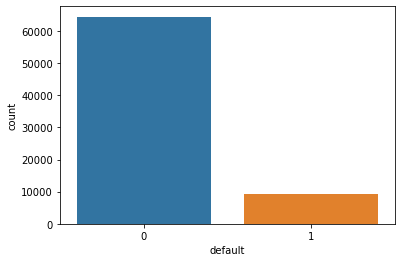

In [197]:
sns.countplot(train['default'])
display(train['default'].value_counts())

Очевидно что выборка распределена неравномерно и недефолтных клиентов заметно больше

Построим графики распределения численных переменных

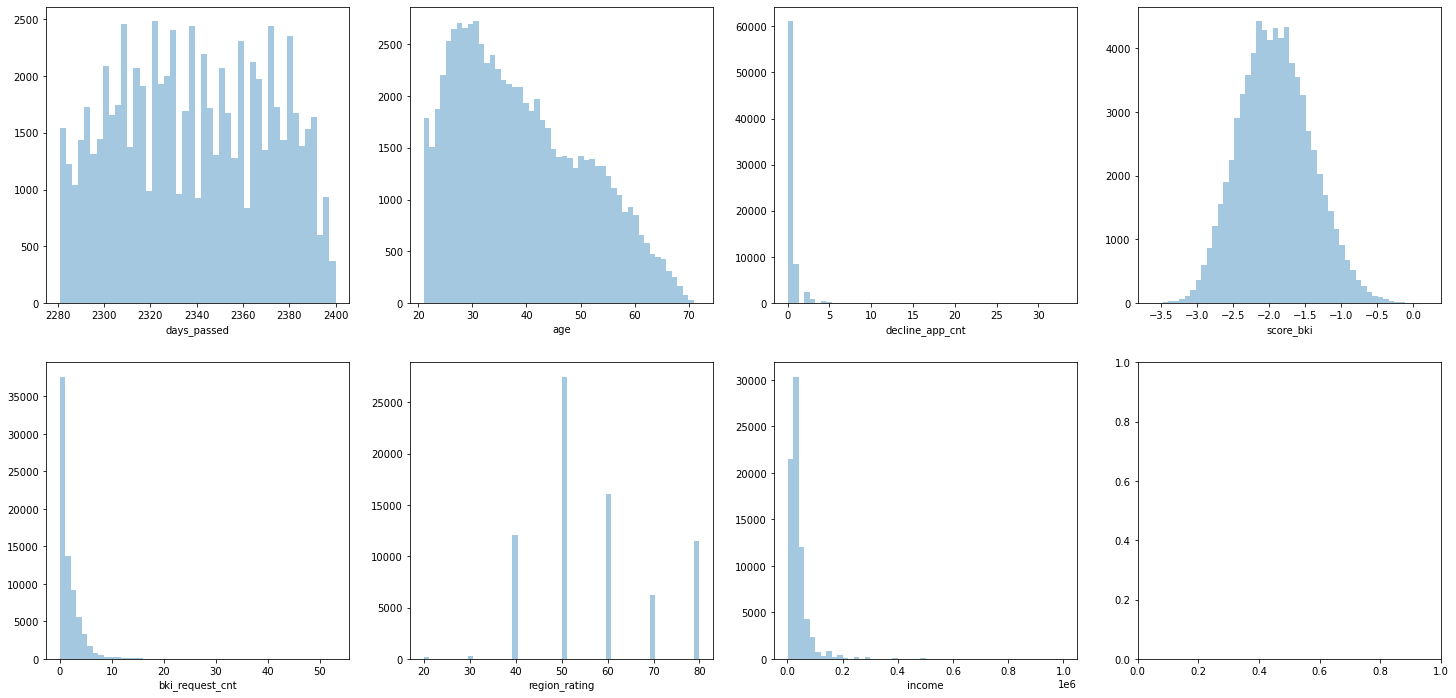

In [198]:
fig, axes = plt.subplots(2, 4, figsize=(25,12))
for col, i in zip(num_cols, range(7)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

In [199]:
train[num_cols].describe()

,days_passed,age,decline_app_cnt,score_bki,bki_request_cnt,region_rating,income
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,2338.964566,39.280641,0.275749,-1.904724,2.000339,56.725701,41099.775417
std,32.121884,11.520378,0.804272,0.498231,2.252073,13.055717,46166.322400
min,2281.000000,21.000000,0.000000,-3.624586,0.000000,20.000000,1000.000000
25%,2311.000000,30.000000,0.000000,-2.259534,0.000000,50.000000,20000.000000
50%,2338.000000,37.000000,0.000000,-1.920823,1.000000,50.000000,30000.000000
75%,2367.000000,48.000000,0.000000,-1.569831,3.000000,60.000000,48000.000000
max,2400.000000,72.000000,33.000000,0.199773,53.000000,80.000000,1000000.000000


Прологарифмируем переменные, которые вызывают вопросы в распределении

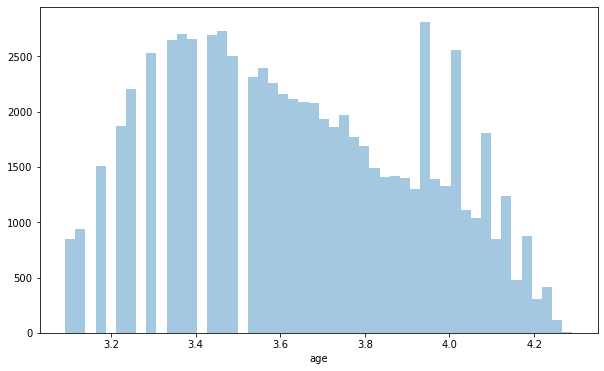

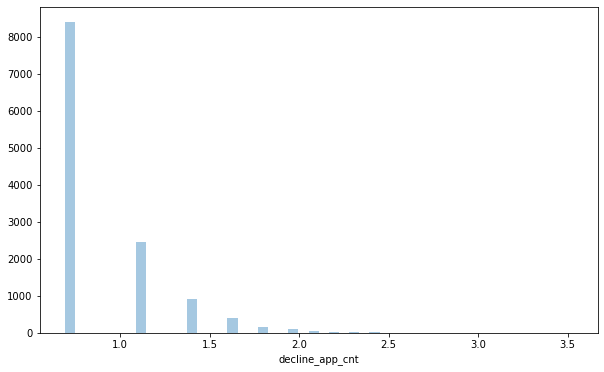

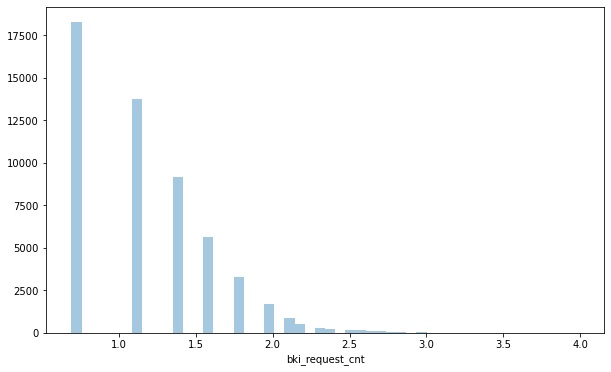

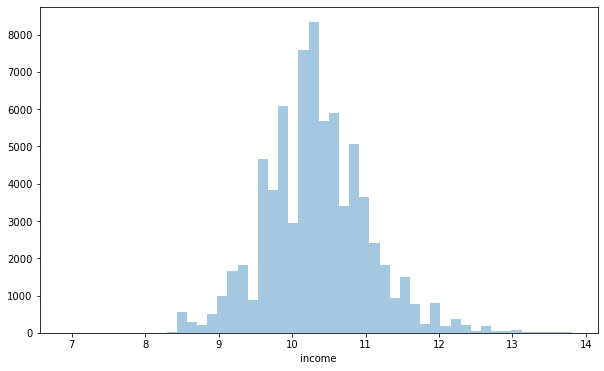

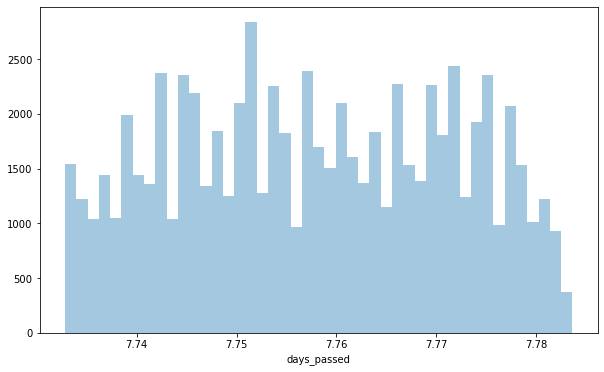

In [200]:
num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'days_passed']
for i in num_cols_log:
    train[i] = np.log(train[i] + 1)
    plt.figure(figsize=(10,6))
    sns.distplot(train[i][train[i] > 0].dropna(), kde=False, rug=False)
    plt.show()

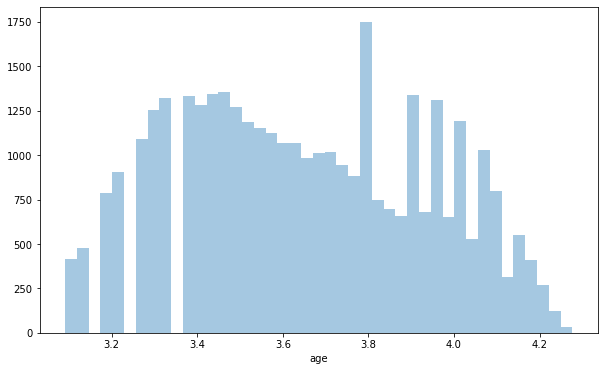

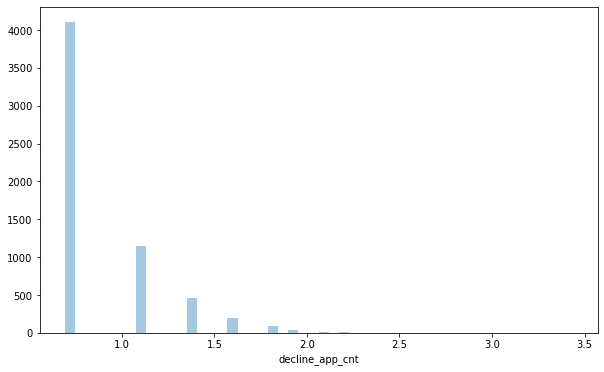

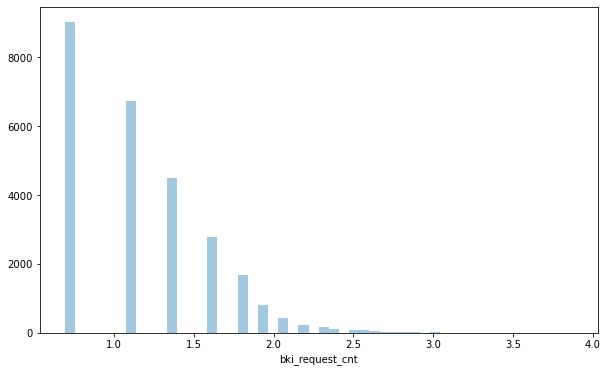

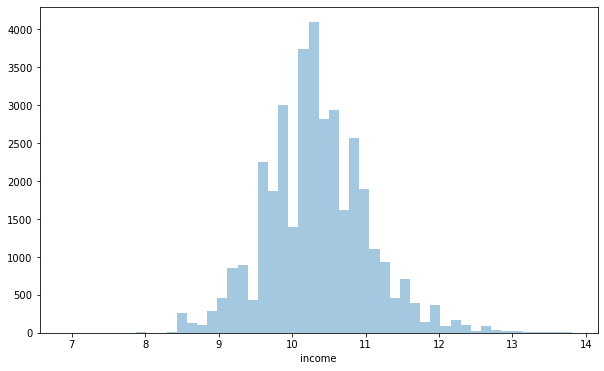

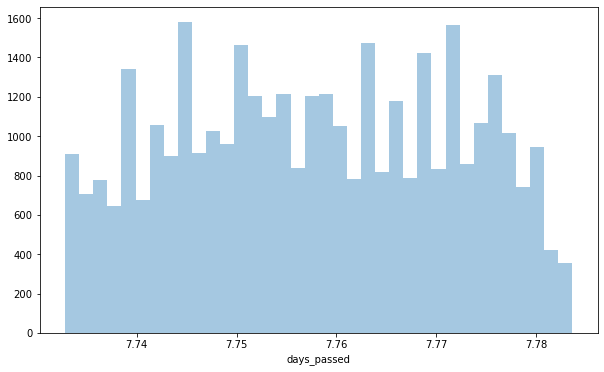

In [201]:
for i in num_cols_log:
    test[i] = np.log(test[i] + 1)
    plt.figure(figsize=(10,6))
    sns.distplot(test[i][test[i] > 0].dropna(), kde=False, rug=False)
    plt.show()

In [202]:
train[num_cols].describe()

,days_passed,age,decline_app_cnt,score_bki,bki_request_cnt,region_rating,income
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,7.757797,3.655332,0.152451,-1.904724,0.878014,56.725701,10.345886
std,0.013728,0.285077,0.362971,0.498231,0.657881,13.055717,0.697702
min,7.732808,3.091042,0.000000,-3.624586,0.000000,20.000000,6.908755
25%,7.745868,3.433987,0.000000,-2.259534,0.000000,50.000000,9.903538
50%,7.757479,3.637586,0.000000,-1.920823,0.693147,50.000000,10.308986
75%,7.769801,3.891820,0.000000,-1.569831,1.386294,60.000000,10.778977
max,7.783641,4.290459,3.526361,0.199773,3.988984,80.000000,13.815512


Построим матрицу корреляций

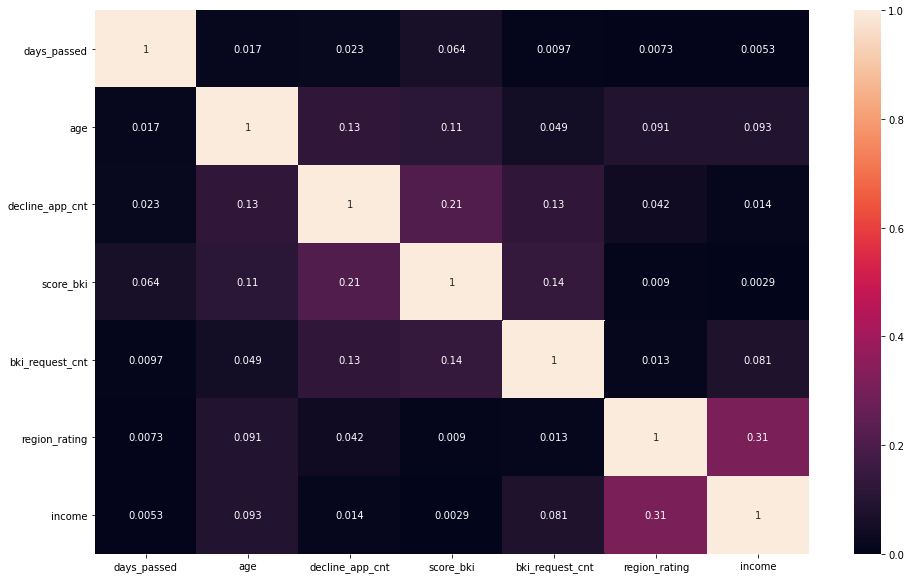

In [203]:
plt.figure(figsize=(16,10))
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1, annot=True, cmap=sns.cm.rocket)

Высокой корреляции между численными признаками не наблюдается, поэтому оставляем их для обучения модели

Проанализируем боксплоты для численных переменных

In [204]:
num_cols

['days_passed',
 'age',
 'decline_app_cnt',
 'score_bki',
 'bki_request_cnt',
 'region_rating',
 'income']

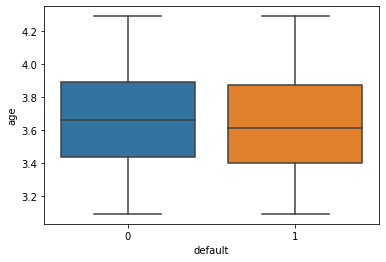

In [205]:
sns.boxplot(x=train.default, y=train.age)

Недефолтные клиенты в среднем старше дефолтных

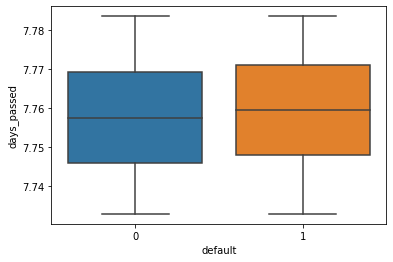

In [206]:
sns.boxplot(x=train.default, y=train.days_passed)

Дефолтные клиенты в среднем оформляли заявки раньше, чем недефолтные. Это может быть связано со множеством факторов, вплоть до эффективности работы системы скоринга в банке в разные моменты времени. Но разница не настолько значительная, чтобы делать какие либо выводы.

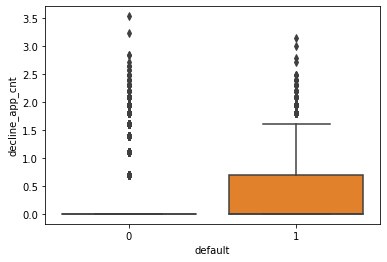

In [207]:
sns.boxplot(x=train.default, y=train.decline_app_cnt)

У дефолтных клиентов количество отклоненных заявок выше, чем у недефолтных

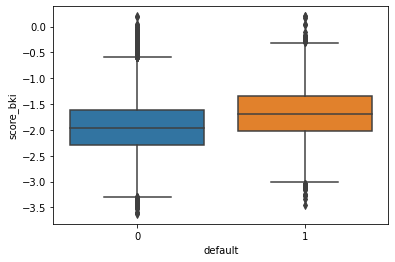

In [208]:
sns.boxplot(x=train.default, y=train.score_bki)

Скоринговый балл в среднем выше у дефолтных клиентов, что довольно необычно (вероятнее всего банк самостоятельно произвел манипуляции с этим признаком, т. к. обычно скоринговый балл положительный от 0 до 850)

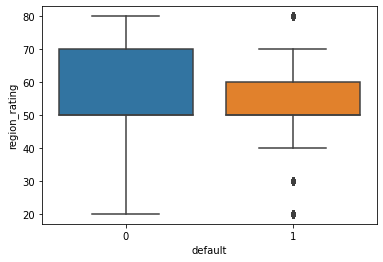

In [209]:
sns.boxplot(x=train.default, y=train.region_rating)

Среднее значение в данном случае больше у недефолтных клиентов, в то время как медианы равны

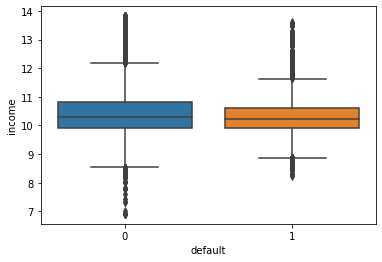

In [210]:
sns.boxplot(x=train.default, y=train.income)

Доход недефолтных клиентов выше, чем доход дефолтных

Проанализируем наличие выбросов в численных переменных после логарифмирования по критерию IQR. Имеет смысл в первую очередь удалить выбросы у максимально значимых признаков, поскольку удаление также приводит к потере информации в данных строках и снижению точности модели 

Признаки, не содержащие выбросов: days_passed, age, region_rating

In [211]:
num_cols

['days_passed',
 'age',
 'decline_app_cnt',
 'score_bki',
 'bki_request_cnt',
 'region_rating',
 'income']

count    73799.000000
mean         0.152451
std          0.362971
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.526361
Name: decline_app_cnt, dtype: float64

25-й перцентиль: 0.0, 75-й перцентиль: 0.0 
IQR: 0.0, Границы выбросов: [0.0, 0.0].


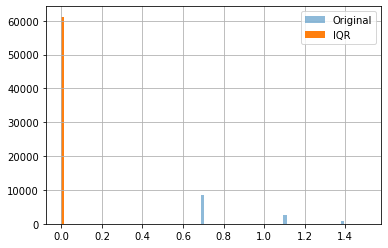

In [212]:
my.print_column_hist(train['decline_app_cnt'], [0,1.5])

В признаке decline_app_cnt много нулевых значений (вплоть до 3го квартиля), но есть и ненулевые значения, которые формально являются выбросами. Удалять их не будем, иначе данный признак потеряет смысл.

count    73799.000000
mean        -1.904724
std          0.498231
min         -3.624586
25%         -2.259534
50%         -1.920823
75%         -1.569831
max          0.199773
Name: score_bki, dtype: float64

25-й перцентиль: -2.259533835, 75-й перцентиль: -1.56983126 
IQR: 0.6897025750000001, Границы выбросов: [-3.2940876975, -0.5352773974999998].


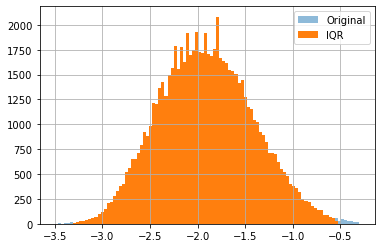

In [213]:
my.print_column_hist(train['score_bki'], [-3.5,-0.3])

In [214]:
row_num = train.shape[0]
shift = 0.2
train = train.query(f"-3.3 - {shift} < score_bki < -0.5 + {shift}")
display(row_num - train.shape[0])

74

Удалим строки с выбросами (по более мягкому критерию, чем IQR, чтобы избежать лишней потери информации), итого 74 строки. Признак распределен нормально и является наиболее значимым среди числовых, поэтому удалить выбросы необходимо

count    73725.000000
mean         0.877859
std          0.657500
min          0.000000
25%          0.000000
50%          0.693147
75%          1.386294
max          3.988984
Name: bki_request_cnt, dtype: float64

25-й перцентиль: 0.0, 75-й перцентиль: 1.3862943611198906 
IQR: 1.3862943611198906, Границы выбросов: [-2.0794415416798357, 3.465735902799726].


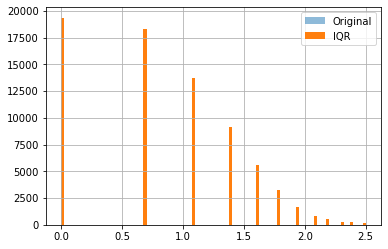

In [215]:
my.print_column_hist(train['bki_request_cnt'], [0,2.5])

In [216]:
row_num = train.shape[0]
train = train.query("-2.1 < bki_request_cnt < 3.5")
display(row_num - train.shape[0])

6

Удалим выбросы из признака bki_request_cnt по критерию IQR, итого 6 строк. Признак также достаточно значимый среди числовых

count    73719.000000
mean        10.345726
std          0.697614
min          6.908755
25%          9.903538
50%         10.308986
75%         10.773377
max         13.815512
Name: income, dtype: float64

25-й перцентиль: 9.90353755128617, 75-й перцентиль: 10.773377246845243 
IQR: 0.8698396955590724, Границы выбросов: [8.598778007947562, 12.078136790183851].


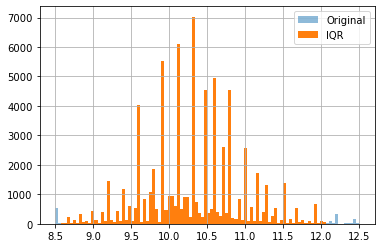

In [217]:
my.print_column_hist(train['income'], [8.5,12.5])

In [218]:
#display(train.shape)
#train = train.query("7.6 < income < 13.1")
#display(train.shape)

Признак income не является значимых среди численных признаков, поэтому удаление выбросов приведет к потере данных. Хотя они присутствуют, удалять их не будем

## Преобразование бинарных и категориальных переменных

Преобразуем бинарные переменные при помощи класса LabelEncoder

In [219]:
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    test[column] = label_encoder.fit_transform(test[column])

    
# убедимся в преобразовании  
display(train.head())
display(test.head())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days_passed,app_date_month,app_date_weekday
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0,7.770645,2,6
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0,7.754053,3,3
2,25887,2014-02-01,SCH,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0,7.770645,2,6
3,16222,2014-01-23,SCH,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0,7.774436,1,4
4,101655,2014-04-18,GRD,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0,7.738052,4,5


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,days_passed,app_date_month,app_date_weekday
0,74835,2014-03-22,GRD,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,50,1,2,10.819798,1,4,0,7.749753,3,6
1,17527,2014-01-24,SCH,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,50,1,2,8.517393,4,3,0,7.774015,1,5
2,75683,2014-03-23,UGR,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,50,1,2,10.308986,1,3,1,7.749322,3,7
3,26883,2014-02-03,SCH,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,40,1,2,9.741027,1,3,0,7.769801,2,1
4,28862,2014-02-04,GRD,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,80,2,3,11.695255,1,3,0,7.769379,2,2


Преобразуем категориальные переменные при помощи OneHotEncoder

In [220]:
cat_cols_final = cat_cols.copy()
# cat_cols_final.remove('education')

x_cat = OneHotEncoder(sparse=False).fit_transform(train[cat_cols_final].values)
y_cat = OneHotEncoder(sparse=False).fit_transform(test[cat_cols_final].values)

print(x_cat.shape)
print(y_cat.shape)

(73719, 30)
(36349, 30)


In [221]:
education_dummy = pd.get_dummies(train['education'])
education_dummy.head()

,ACD,GRD,PGR,SCH,UGR
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,1,0,0,0


## Значимость непрерывных переменных

Text(0.5, 0, 'F-value')

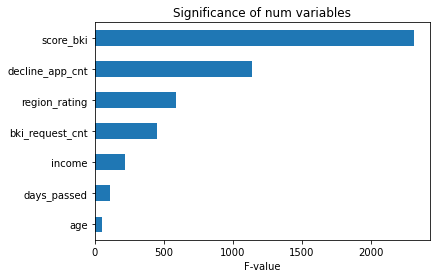

In [222]:
imp_num = Series(f_classif(train[num_cols], train['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.title('Significance of num variables')
plt.xlabel('F-value')

## Значимость бинарных и категориальных переменных

Text(0.5, 1.0, 'Significance of bin variables')

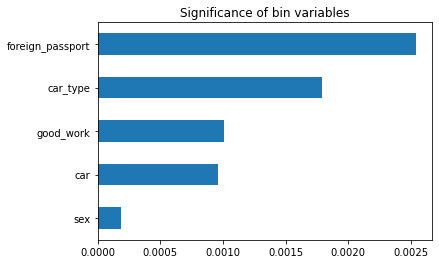

In [223]:
# Значимость бинарных признаков

imp_bin = Series(mutual_info_classif(train[bin_cols], train['default'],
                                     discrete_features=True), index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')
plt.title('Significance of bin variables')

Text(0.5, 1.0, 'Significance of cat variables')

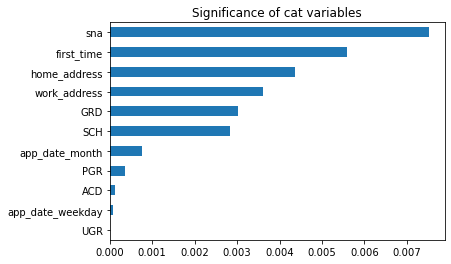

In [224]:
# Значимость категориальных признаков

# new_cat_cols = ['app_date_month', 'app_date_weekday', 'home_address', 'work_address', 'sna', 'first_time']
new_cat_cols = cat_cols.copy()
new_cat_cols.remove('education')

imp_cat = pd.Series(mutual_info_classif(pd.concat([train[new_cat_cols], education_dummy], axis=1),
                                        train['default'], discrete_features=True),
                    index=pd.concat([train[new_cat_cols], education_dummy], axis=1).columns)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')
plt.title('Significance of cat variables')

Исходя из данных графиков можно сделать вывод о малозначимости признака sex и age. А также мы можем увидеть значимость различных степеней образования на наш результат и наибольший вклад приносит признак GRD (graduate).

## Подготовка данных к машинному обучению

In [225]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

x_tr = poly.fit_transform(train[num_cols].values)
y_test = poly.fit_transform(test[num_cols].values)

Стандартизируем числовые переменные

In [226]:
# Scaling num variables

x_num = StandardScaler().fit_transform(x_tr)
y_num = StandardScaler().fit_transform(y_test)
print(x_num)
print(y_num)

[[ 0.          0.93612642  1.71099592 ... -0.56418118 -0.64515379
  -0.78673133]
 [ 0.         -0.27241913  1.53985257 ... -0.56418118 -0.62767314
  -0.71415493]
 [ 0.          0.93612642 -1.39349043 ...  1.91429931  1.51993143
  -0.08508629]
 ...
 [ 0.         -1.56494127 -0.66514494 ...  1.91429931  1.72968457
   0.49722852]
 [ 0.          1.7915978  -0.89152947 ... -0.56418118 -0.75036592
  -1.21511719]
 [ 0.          1.21219665 -0.35080853 ... -0.56418118 -0.53894338
  -0.33960722]]
[[ 0.         -0.59458174 -0.88333898 ... -0.56902243 -0.31968854
   0.65637674]
 [ 0.          1.18041365  0.12606863 ... -0.56902243 -1.06274348
  -2.40227913]
 [ 0.         -0.62610963  0.97850869 ... -0.56902243 -0.48454293
  -0.0850894 ]
 ...
 [ 0.         -0.84718614 -0.65688874 ... -0.56902243 -0.260849
   0.92970115]
 [ 0.          1.70156737 -1.12541848 ...  1.90270276  1.51166781
  -0.0850894 ]
 [ 0.         -0.43714575  0.0372345  ... -0.56902243 -0.70823148
  -1.03384706]]


И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [227]:
# Merge

X = np.hstack([x_num, train[bin_cols].values, x_cat])
Y = train['default'].values

id_test = test.client_id
test = np.hstack([y_num, test[bin_cols].values, y_cat])

In [228]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle=True)

## Регуляризация

In [229]:
from sklearn.model_selection import GridSearchCV

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)
model = LogisticRegression()
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

best_penalty = best_model.best_estimator_.get_params()['penalty']
best_с = best_model.best_estimator_.get_params()['C']

print('Лучший penalty:', best_penalty)
print('Лучшее C:', best_с)

Лучший penalty: l2
Лучшее C: 3593.813663804626


Обучим модель

In [230]:
lgr = LogisticRegression(penalty=best_penalty, C=best_с, max_iter=500)
lgr.fit(X_train, y_train)

LogisticRegression(C=3593.813663804626, max_iter=500)

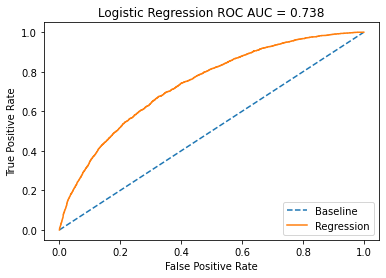

ROC AUC baseline = 0.740
ROC AUC current = 0.738


In [231]:
probs = lgr.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

print("ROC AUC baseline = 0.740")
print("ROC AUC current = %0.3f" % roc_auc)

In [232]:
Series(y_test).value_counts()

0    19295
1     2821
dtype: int64

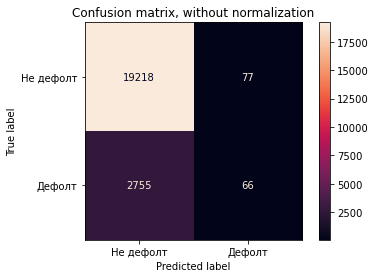

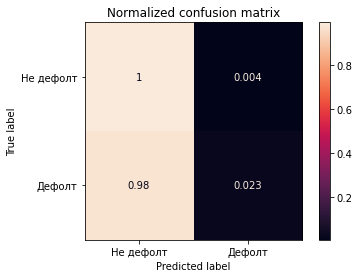

In [233]:
class_names = ['Не дефолт', 'Дефолт']
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
classifier = lgr
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=sns.cm.rocket,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

Оценим качество предсказания оптимизированной модели на валидационной выборке. При достаточно высокой ROC AUC метрике, доля верно угаданных дефолтных клиентов составляет всего 2% от общего количества (66 из 2821).Огромная ошибка второго рода приведет к существенному убытку, что недопустимо. Вывод - модель нуждается в дальнейшей доработке, чтобы увеличить вероятность определения дефолтных клиентов.

Обучим модель на всем датасете

In [234]:
lgr = LogisticRegression(penalty=best_penalty, C=best_с, max_iter=500)
lgr.fit(X, Y)
probs = lgr.predict_proba(test)
probs = probs[:,1]

In [235]:
my_submission = pd.DataFrame({'client_id': id_test, 
                            'default': probs})
my_submission.to_csv('submission.csv', index=False)

my_submission

,client_id,default
0,74835,0.043761
1,17527,0.361516
2,75683,0.068965
3,26883,0.077686
4,28862,0.019158
...,...,...
36344,83775,0.393252
36345,106254,0.015187
36346,81852,0.320552
36347,1971,0.205317
